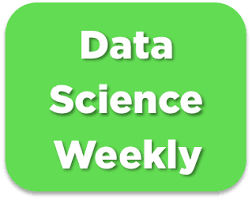

# Challenge : predict conversions 🏆🏆
In this project, you will participate to a machine learning competition like the ones that are organized by https://www.kaggle.com/. You will be able to work with jupyter notebooks as usual, but in the end you'll have to submit your model's predictions to your teacher/TA, so your model's performances will be evaluated in an independent way. The scores achieved by the different teams will be stored into a leaderboard 🏅🏅

## Description of a machine learning challenge 🚴🚴
- In machine learning challenges, the dataset is always separated into to files :
    - *data_train.csv* contains **labelled data**, which means there are both X (explanatory variables) and Y (the target to be predicted). You will use this file to train your model as usual : make the train/test split, preprocessings, assess performances, try different models, fine-tune hyperparameters etc...
    - *data_test.csv* contains "new" examples that have not be used to train the model, in the same format as in *data_train.csv* but it is **unlabeled**, which means the target Y has been removed from the file. Once you've trained a model, you will use *data_test.csv* to make some predictions that you will send to the organizing team. They will then be able to assess the performances of your model in an independent way, by preventing cheating 🤸
- Your model's predictions will be compared to the true labels and releases a leaderboard where the scores of all the teams around the world are stored
- All the participants are informed about the metric that will be used to assess the scores. You have to make sure you're using the same metric to evaluate your train/test performances !

## Company's Description 📇
www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !

## Project 🚧
The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

They designed a competition aiming at building a model that allows to predict the *conversions* (i.e. when a user will subscribe to the newsletter). To do so, they open-sourced a dataset containing some data about the traffic on their website. To assess the rankings of the different competing teams, they decided to use the **f1-score**.

## Goals 🎯
The project can be cut into four steps :
- Part 1 : make an EDA and the preprocessings and train a baseline model with the file *data_train.csv*
- Part 2 : improve your model's f1-score on your test set (you can try feature engineering, feature selection, regularization, non-linear models, hyperparameter optimization by grid search, etc...)
- Part 3 : Once you're satisfied with your model's score, you can use it to make some predictions with the file *data_test.csv*. You will have to dump the predictions into a .csv file that will be sent to Kaggle (actually, to your teacher/TA 🤓). You can make as many submissions as you want, feel free to try different models !
- Part 4 : Take some time to analyze your best model's parameters. Are there any lever for action that would help to improve the newsletter's conversion rate ? What recommendations would you make to the team ?

## Deliverable 📬
To complete this project, your team should: 
- Create some relevant figures for EDA
- Train at least one model that predicts the conversions and evaluate its performances (f1, confusion matrices)
- Make at least one submission to the leaderboard 
- Analyze your best model's parameters and try to make some recommendations to improve the conversion rate in the future


## Helpers 🦮

To help you with the methodology, we created a template (**02-Conversion_rate_challenge_template.ipynb**) in which all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the EDA/preprocessing/training steps ! May the force be with you 🧨🧨 

In [1]:
# Data manipulation and viz
import pandas as pd , numpy as np 
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno
from tqdm import tqdm

# Preprocess and model selection
from sklearn.preprocessing import StandardScaler , MinMaxScaler , QuantileTransformer , RobustScaler
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV , RepeatedStratifiedKFold , StratifiedKFold
from sklearn.decomposition import PCA
from BestSetUp import BestSetUp # My custom class 
from pyod.models.iforest import IForest
from sklearn.metrics import make_scorer, f1_score , accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVC

# Modeling 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 


import warnings
warnings.filterwarnings('ignore')
np.random.seed(123456)

## EDA

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df_copy = df.copy(deep=True)
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


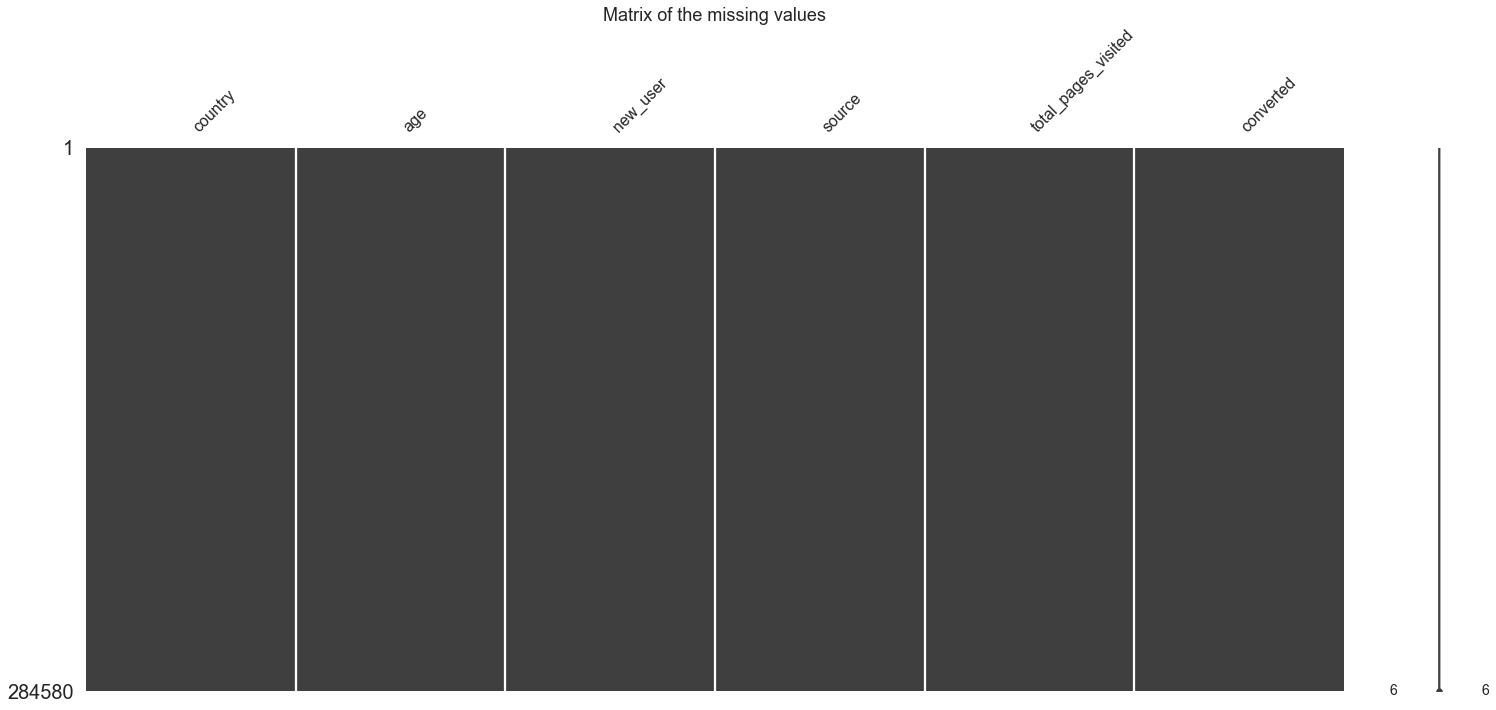

In [36]:
msno.matrix(df) # No null values
plt.title('Matrix of the missing values')
plt.show()

In [5]:
print('Unique countries : ' , df['country'].unique())
print('Unique source : ' , df['source'].unique())

Unique countries :  ['China' 'UK' 'Germany' 'US']
Unique source :  ['Direct' 'Ads' 'Seo']


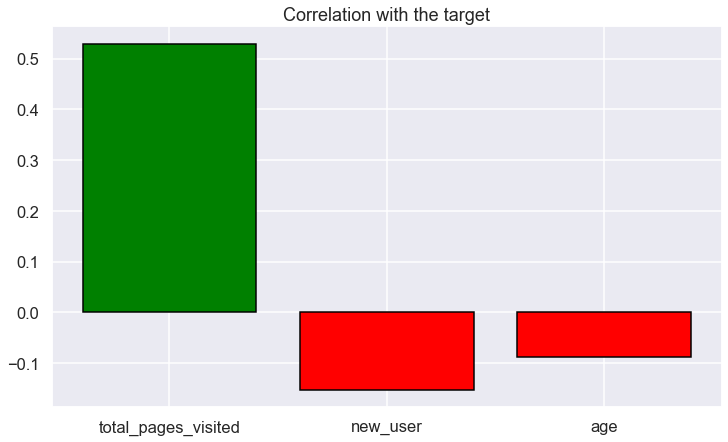

In [35]:
def check_correlation(target : str , df : pd.DataFrame , method : str):
    """Returns a sorted dataframe with the columns names and their correlation with 
    the specified target variable"""
   
    cor = [df[target].corr(df[col] , method=method) for col in df.columns]
    dictio = dict(zip(df.columns , cor))

    to_ret = pd.DataFrame({'columns' : dictio.keys()  , 'correlation_with_the_specified_target' : dictio.values()})\
    .sort_values(by=['correlation_with_the_specified_target'] , ascending=False)[1:]

    to_ret['abs_correlation'] = abs(to_ret['correlation_with_the_specified_target']) 


    return to_ret.sort_values(by='abs_correlation' , ascending=False).drop('abs_correlation' , axis=1)


corr_ = check_correlation(target='converted' , df=df.drop(['country' , 'source'] , axis=1) , method='pearson')

sns.set_context('talk')
sns.set_style('darkgrid')

colors = ['green' if corr >= 0 else 'red' for corr in corr_['correlation_with_the_specified_target']]
plt.figure(figsize=(12,7))
plt.bar(corr_['columns'] , corr_['correlation_with_the_specified_target'] , color=colors , edgecolor='black')
plt.title('Correlation with the target')
plt.show()

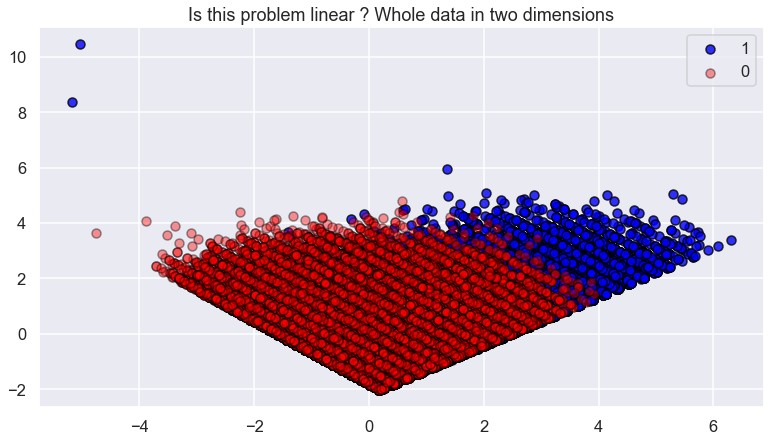

In [7]:
# Is this problem linear ? 
dummies = pd.get_dummies(df[['country' , 'source']])
ohe_df = df.copy()

ohe_df[dummies.columns] = dummies
ohe_df = ohe_df.drop(['country' , 'source'] , axis=1)
ohe_df[['total_pages_visited' , 'age']] = StandardScaler().fit_transform(ohe_df[['total_pages_visited' , 'age']])

pca_df = pd.DataFrame(data=PCA(n_components=2).fit_transform(ohe_df) , columns=['PC1' , 'PC2'])
pca_df['converted'] = df['converted']

plt.figure(figsize=(13,7))
plt.scatter(x=pca_df[pca_df['converted'] == 1]['PC1'] , y=pca_df[pca_df['converted'] == 1]['PC2'] , color='blue' , alpha=0.8 , edgecolor='black' , label='1')
plt.scatter(x=pca_df[pca_df['converted'] == 0]['PC1'] , y=pca_df[pca_df['converted'] == 0]['PC2'] , color='red' , alpha=0.4, edgecolor='black', label='0')
plt.legend()
plt.title('Is this problem linear ? Whole data in two dimensions')
plt.show() # It seems so


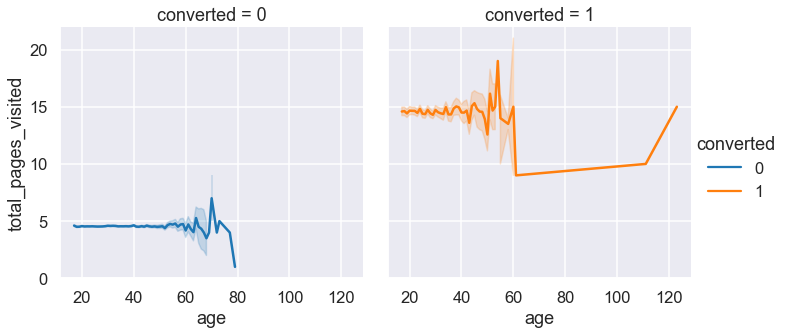

In [8]:
sns.relplot(
    data=df, kind="line",
    x="age", y="total_pages_visited", col="converted",
    hue="converted", linewidth=2.5
)

plt.show()

In [9]:
# Is the target variable balanced ? 
print('Percentage of converted persons in the dataset : ' , round(len(df[df['converted'] == 1]) / len(df) , 3) * 100 , '%') # Not at all

Percentage of converted persons in the dataset :  3.2 %


## Modeling

In [13]:
sample_ = df.sample(n=20_000)
X = sample_.drop('converted' , axis=1)
y = sample_[['converted']]


scalers = [StandardScaler() , MinMaxScaler() , QuantileTransformer() , RobustScaler()]

models = [LogisticRegression(solver='saga' , max_iter=5000) , RandomForestClassifier(n_estimators=200) , XGBClassifier()]

best_set_up_2 = BestSetUp(X=X , y=y , models=models , scalers=scalers , n_cv=10 , multiclass=False)
best_string = best_set_up_2.get_best_setup()
best_model = best_set_up_2.get_best_model()
print(best_string)

Choosing model ...


100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


Choosing scaler ...


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Choosing categorical preprocessing ...
Dealing with outliers ...

Best model : LogisticRegression(max_iter=5000, solver='saga')
Best scaler : StandardScaler()
Best categorical processing : One-Hot-Encoding        
With or without outliers : Better keep the outliers


In [24]:
def preprocess(X : pd.DataFrame):
    X_ = X.copy()
    dummies = pd.get_dummies(X[['country' , 'source']])
    X_[dummies.columns] = dummies
    X_ = X_.drop(['country' , 'source'] , axis=1)
    X_[['total_pages_visited' , 'age']] = StandardScaler().fit_transform(X[['total_pages_visited' , 'age']])
    return X_

X = preprocess(df.drop('converted' , axis=1))
y = df['converted']

In [4]:
# Let's optimize a Logistic regression using hyperopt (Bayesian approach)
from hyperopt import fmin , tpe , hp


space = {
         'C' : hp.uniform('C' , 0.001 , 10_000) , 
         'solver' : hp.choice('solver' , ["saga" , 'lbfgs' , 'sag' , 'liblinear' , 'newton-cg'])
        }


def objective(params):

    clf = LogisticRegression(C=params['C'], solver=params['solver'] , max_iter=5000 , n_jobs=-1)
    cv = RepeatedStratifiedKFold()
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1').mean()
    return -score


best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300)
print(best)

100%|██████████| 300/300 [15:15:27<00:00, 183.09s/trial, best loss: -0.7638860980326578]   
{'C': 8076.989596273913, 'solver': 4}


In [5]:
# Creating the model with the best parameters
best_model = LogisticRegression(C=8076.989596273913 , solver='newton-cg' , max_iter=5_000 , penalty='l2')

print('Cross valid log ...')
cv = RepeatedStratifiedKFold(n_splits=5) # More robust estimation
scores_log = cross_val_score(estimator=best_model, X=X , y=y , scoring='f1' , cv=cv)

print('Mean log : ' , np.mean(scores_log))
print('Std log : ' , np.std(scores_log))

Cross valid log ...
Mean log :  0.763773539954
Std log :  0.005924101666689175


# Trying stacking models

In [4]:
# Trying some stacking models with the best model as meta-classifiers
model = LogisticRegression(C=8076.989596273913 , solver='newton-cg' , max_iter=5_000 , penalty='l2')
model1 = StackingClassifier(classifiers=[SVC(kernel='linear')  , LogisticRegression(class_weight='balanced') , LogisticRegression(C=0.1)] , meta_classifier=model)
model2 = StackingClassifier(classifiers=[SVC(kernel='linear') , DecisionTreeClassifier(max_depth=7) , LogisticRegression(C=0.1)] , meta_classifier=model)
model3 = StackingClassifier(classifiers=[RandomForestClassifier() , AdaBoostClassifier() , XGBClassifier()] , meta_classifier=model)

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.33 , stratify=y)

print('Fitting model 1 ...')
model1.fit(X_train , y_train)
preds = model1.predict(X_test)
print('F1 score model1 : ' , f1_score(y_test , preds))

print('Fitting model 2 ...')
model2.fit(X_train , y_train)
preds = model2.predict(X_test)
print('F1 score model2 : ' , f1_score(y_test , preds))


print('Fitting model 3 ...')
model3.fit(X_train , y_train)
preds = model3.predict(X_test)
print('F1 score model3 : ' , f1_score(y_test , preds))

print('Fitting model ...')
model.fit(X_train , y_train)
preds = model.predict(X_test)
print('F1 score model : ' , f1_score(y_test , preds))

Fitting model 1 ...
F1 score model1 :  0.7641977577651167
Fitting model 2 ...
F1 score model2 :  0.7524454477050414
Fitting model 3 ...
F1 score model3 :  0.7435759209344116
Fitting model ...
F1 score model :  0.7651473549331869


In [15]:
# One last one
model = LogisticRegression(C=8076.989596273913 , solver='newton-cg' , max_iter=5_000 , penalty='l2')
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.33 , stratify=y)


classifiers = [LogisticRegression(C=0.01 , max_iter=5000) , LogisticRegression(penalty='l1' , solver="saga", max_iter=5000)
              , LogisticRegression(class_weight='balanced' , max_iter=5000)]

stack = StackingClassifier(classifiers=classifiers , meta_classifier=model)

stack.fit(X_train , y_train)

preds = stack.predict(X_test)
print('F1 score model : ' , f1_score(y_test , preds))

F1 score model :  0.7695390781563125


In [14]:
# Confirm the results
print('Cross valid stacking ...')
cv = RepeatedStratifiedKFold(n_splits=5) 
scores = cross_val_score(estimator=stack, X=X , y=y , scoring='f1' , cv=cv)

print('Mean stacking : ' , np.mean(scores))
print('Std stacking : ' , np.std(scores))

print('Cross valid log ...')
cv = RepeatedStratifiedKFold(n_splits=5) 
scores = cross_val_score(estimator=model, X=X , y=y , scoring='f1' , cv=cv)

print('Mean log : ' , np.mean(scores))
print('Std log : ' , np.std(scores))

Cross valid stacking ...
Mean stacking :  0.7636325374904868
Std stacking :  0.00767298699899239
Cross valid log ...
Mean log :  0.7636190801342506
Std log :  0.007487523836269438


In [28]:
# The best performing model
stack.fit(X , y)

# Load and predict on the testing data
test = pd.read_csv('conversion_data_test.csv')

prepro_test = preprocess(test)
test['converted'] = stack.predict(prepro_test)
test.to_csv('conversion_data_test_predictions_lucas_fernandez.csv' , index=False)

In [30]:
test.head() # Sanity check

,country,age,new_user,source,total_pages_visited,converted
0,UK,28,0,Seo,16,1
1,UK,22,1,Direct,5,0
2,China,32,1,Seo,1,0
3,US,32,1,Ads,6,0
4,China,25,0,Seo,3,0


## Analysis of the coefficients and recommandations

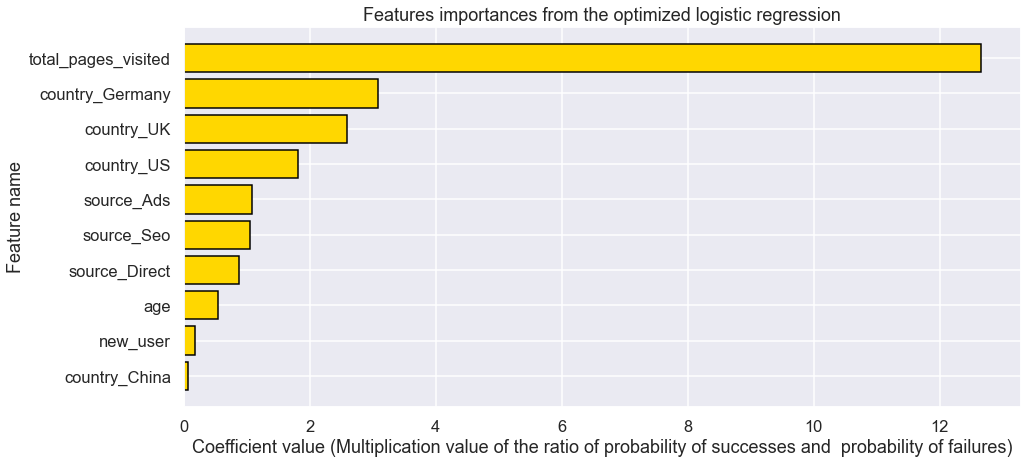

In [34]:
coefs = np.exp(model.coef_)[0] # To display interpretable results
features_names = model.feature_names_in_ 
to_plot = pd.DataFrame({'Feature' : features_names , 'Coefficient' : coefs}).sort_values(by='Coefficient' , ascending=True)
assert len(coefs) == len(features_names)


plt.figure(figsize=(15,7))
plt.barh(to_plot['Feature'] , to_plot['Coefficient'] , color='gold' , edgecolor='black')
plt.xlabel('Coefficient value (Multiplication value of the ratio of probability of successes and  probability of failures)')
plt.ylabel('Feature name')
plt.title('Features importances from the optimized logistic regression')
plt.show()

## Conclusion : 
- The most important variable to predict conversion rate is 'total_pages_visited'. The most visited pages , the higher the chances of an user being converted.
- Country is the second one , especialy if a user comes from germany or UK , the odds of him being converted increase.
- The best model to predict the conversion rate appears to be the Logistic regression , which is a very simple and interpretable model , which works well on linearly separable problems. I used a combinaison of differents logistic regression with different parameters (a stacking model with three classifiers and one meta-classifiers) to get the most of the available data. 